# Day 3: PCA for Trading

## 🎯 Learning Objectives
- Understand Principal Component Analysis
- Apply to factor extraction
- Build PCA-based trading strategies

---

## 📚 Theory: PCA

### Goal
Find orthogonal directions of maximum variance.

### Math
$$\Sigma v = \lambda v$$

Where:
- $\Sigma$: Covariance matrix
- $v$: Eigenvector (principal component)
- $\lambda$: Eigenvalue (variance explained)

### Finance Applications
- Statistical factor extraction
- Dimensionality reduction
- Market factor identification

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252

# Download sector ETFs
tickers = ['XLK', 'XLF', 'XLE', 'XLV', 'XLI', 'XLY', 'XLP', 'XLU', 'XLB', 'XLRE']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(returns)} days, {len(tickers)} sectors")

📥 Downloading data...
✅ Data: 1254 days, 10 sectors


In [2]:
# Apply PCA
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns)

pca = PCA()
pca.fit(returns_scaled)

# Variance explained
var_explained = pca.explained_variance_ratio_
cum_var = np.cumsum(var_explained)

print("\n" + "="*60)
print("PCA VARIANCE EXPLAINED")
print("="*60)
for i, (var, cum) in enumerate(zip(var_explained, cum_var)):
    print(f"PC{i+1}: {var:.1%} (Cumulative: {cum:.1%})")


PCA VARIANCE EXPLAINED
PC1: 60.5% (Cumulative: 60.5%)
PC2: 11.5% (Cumulative: 71.9%)
PC3: 8.6% (Cumulative: 80.5%)
PC4: 4.8% (Cumulative: 85.4%)
PC5: 3.5% (Cumulative: 88.9%)
PC6: 3.3% (Cumulative: 92.2%)
PC7: 2.9% (Cumulative: 95.0%)
PC8: 2.1% (Cumulative: 97.1%)
PC9: 1.7% (Cumulative: 98.8%)
PC10: 1.2% (Cumulative: 100.0%)


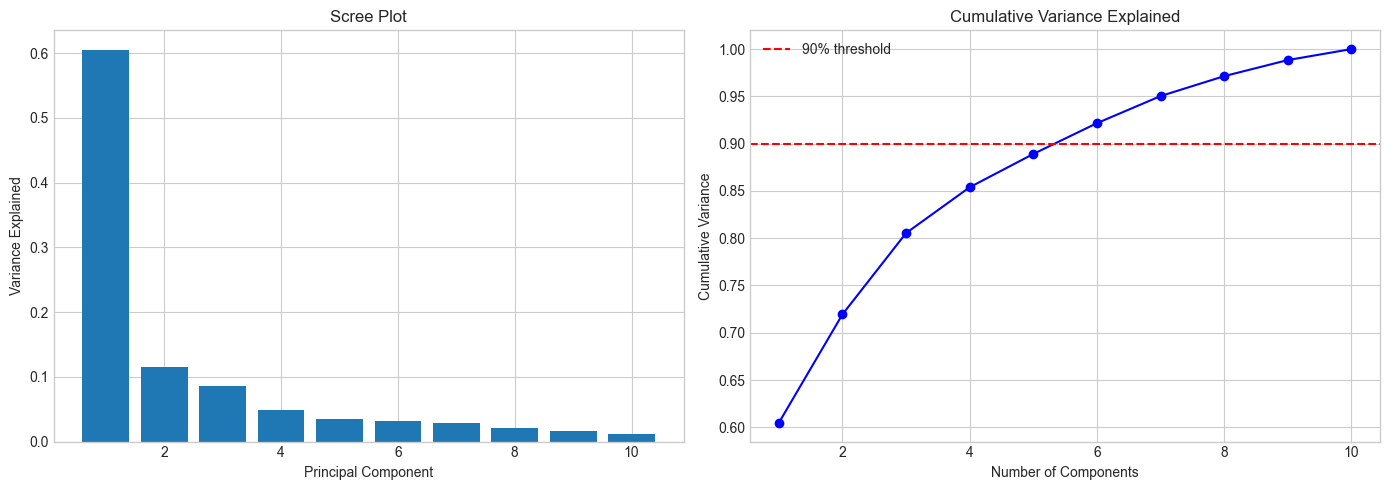

In [3]:
# Plot variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, len(var_explained)+1), var_explained)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Scree Plot')

axes[1].plot(range(1, len(cum_var)+1), cum_var, 'bo-')
axes[1].axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()

plt.tight_layout()
plt.show()


📊 Factor Loadings:
      PC1 (Market)    PC2    PC3
XLK          0.363 -0.127  0.116
XLF          0.219 -0.319  0.771
XLE          0.352 -0.180  0.133
XLV          0.372 -0.179  0.039
XLI          0.306 -0.332 -0.438
XLY          0.290  0.452  0.043
XLP          0.328  0.282 -0.069
XLU          0.266  0.524  0.120
XLB          0.311  0.253 -0.111
XLRE         0.325 -0.290 -0.384


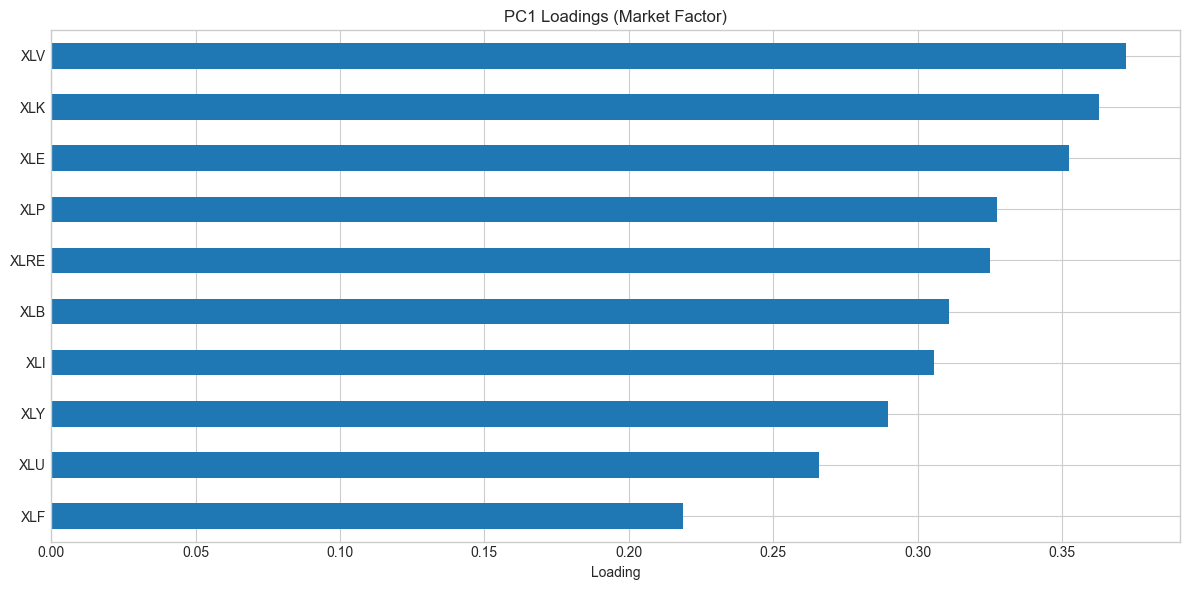

In [4]:
# Analyze PC1 (market factor)
loadings = pd.DataFrame(
    pca.components_[:3].T,
    columns=['PC1 (Market)', 'PC2', 'PC3'],
    index=tickers
)

print("\n📊 Factor Loadings:")
print(loadings.round(3))

# Visualize loadings
fig, ax = plt.subplots(figsize=(12, 6))
loadings['PC1 (Market)'].sort_values().plot(kind='barh', ax=ax)
ax.set_title('PC1 Loadings (Market Factor)')
ax.set_xlabel('Loading')
plt.tight_layout()
plt.show()

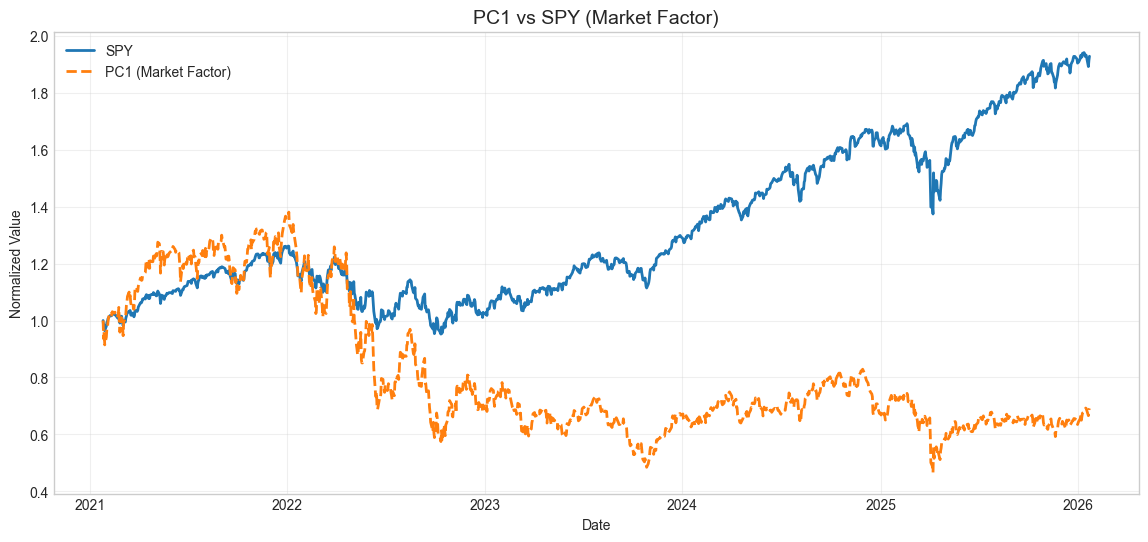


📊 Correlation between SPY and PC1: 0.92


In [5]:
# Extract PC scores (factor returns)
pc_scores = pca.transform(returns_scaled)
pc_returns = pd.DataFrame(
    pc_scores[:, :3],
    columns=['PC1_return', 'PC2_return', 'PC3_return'],
    index=returns.index
)

# PC1 as market factor
pc_returns['PC1_cum'] = (1 + pc_returns['PC1_return'] * 0.01).cumprod()  # Scale down

# Compare with SPY
spy = yf.download('SPY', start=start_date, end=end_date, progress=False, auto_adjust=True)['Close']
if isinstance(spy, pd.DataFrame):
    spy = spy.iloc[:, 0]
spy_returns = spy.pct_change().dropna()
spy_cum = (1 + spy_returns).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(spy_cum.index, spy_cum.values / spy_cum.values[0], label='SPY', linewidth=2)
plt.plot(pc_returns.index, pc_returns['PC1_cum'] / pc_returns['PC1_cum'].iloc[0], 
         label='PC1 (Market Factor)', linewidth=2, linestyle='--')
plt.title('PC1 vs SPY (Market Factor)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Correlation
aligned = pd.DataFrame({'SPY': spy_returns, 'PC1': pc_returns['PC1_return']}).dropna()
corr = aligned.corr().iloc[0, 1]
print(f"\n📊 Correlation between SPY and PC1: {corr:.2f}")

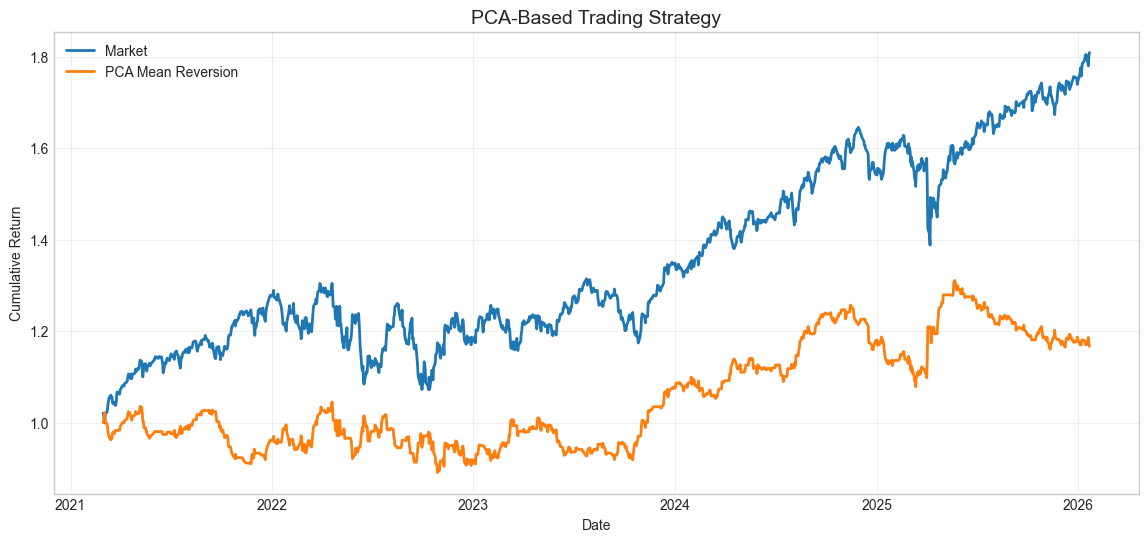

In [6]:
# PCA-based mean reversion strategy
# When PC2/PC3 deviates significantly, bet on reversion

df = pc_returns.copy()
window = 20

# Z-score of PC2
df['PC2_zscore'] = (df['PC2_return'].rolling(5).sum() - 
                    df['PC2_return'].rolling(window).sum().rolling(5).mean()) / \
                   df['PC2_return'].rolling(window).sum().rolling(5).std()

# Signal: Mean reversion on PC2
df['signal'] = np.where(df['PC2_zscore'] > 1, -1,
                       np.where(df['PC2_zscore'] < -1, 1, 0))

# Use equal-weighted sector portfolio
market_return = returns.mean(axis=1)
df['market_return'] = market_return
df['strategy_return'] = df['signal'].shift(1) * df['market_return']

df = df.dropna()
df['strategy_cum'] = (1 + df['strategy_return']).cumprod()
df['market_cum'] = (1 + df['market_return']).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['market_cum'], label='Market', linewidth=2)
plt.plot(df.index, df['strategy_cum'], label='PCA Mean Reversion', linewidth=2)
plt.title('PCA-Based Trading Strategy', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Next day prediction based on PCA
latest_returns = returns.iloc[-1:]
latest_scaled = scaler.transform(latest_returns)
latest_pc = pca.transform(latest_scaled)[0]

print("\n" + "="*60)
print("📊 PCA ANALYSIS FOR TODAY")
print("="*60)
print(f"\nDate: {returns.index[-1].strftime('%Y-%m-%d')}")
print(f"\nPrincipal Component Values:")
print(f"  PC1 (Market): {latest_pc[0]:.3f}")
print(f"  PC2 (Sector Rotation): {latest_pc[1]:.3f}")
print(f"  PC3: {latest_pc[2]:.3f}")
print(f"\nPC2 Z-score: {df['PC2_zscore'].iloc[-1]:.2f}")
signal = df['signal'].iloc[-1]
print(f"\n🎯 Signal: {'📈 LONG' if signal == 1 else '📉 SHORT' if signal == -1 else '⏸️ NEUTRAL'}")


📊 PCA ANALYSIS FOR TODAY

Date: 2026-01-22

Principal Component Values:
  PC1 (Market): 0.758
  PC2 (Sector Rotation): -0.646
  PC3: -0.418

PC2 Z-score: -2.41

🎯 Signal: 📈 LONG


---

## 🏢 Real-World Applications

| Company | PCA Use Case |
|---------|-------------|
| BlackRock | Factor extraction |
| AQR | Statistical arbitrage |
| Barclays | Risk decomposition |

---
## 📅 Tomorrow: DBSCAN & Anomaly Detection